In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import time, date, datetime
import re
import us
from city_to_state import city_to_state_dict

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = []

In [4]:
with open('tweets2.json') as f1:
    for line in f1:
        data.append(json.loads(line))

with open('tweets3.json') as f2:
    for line in f2:
        data.append(json.loads(line))

with open('tweets4.json') as f3:
    for line in f3:
        data.append(json.loads(line))

In [5]:
from itertools import chain
data_flat = list(chain.from_iterable(list(chain.from_iterable(data))))

In [6]:
len(data_flat)

50400

In [7]:
data_flat[0]

{'created_at': 'Sat Apr 18 23:59:59 +0000 2020',
 'id': 1251661788451610624,
 'id_str': '1251661788451610624',
 'text': 'Jackson took me on a quarantine date aka we’re sitting in the backyard drinking bud light together',
 'truncated': False,
 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1128419282231222272,
  'id_str': '1128419282231222272',
  'name': 'sarah 🦋',
  'screen_name': 'sarahbetholson',
  'location': 'Verdigris, OK',
  'description': 'real g’s move in silence like lasagna',
  'url': None,
  'entities': {'description': {'urls': []}},
  'protected': False,
  'followers_count': 93,
  'friends_count': 94,
 

In [8]:
total = 0
stripped_data = []
for i in range(len(data_flat)):
    if data_flat[i] != None:
        batch = {}
        batch['created'] = data_flat[i].get("created_at", np.nan)
        batch['id'] = data_flat[i].get("id", np.nan)
        batch['user_id'] = data_flat[i]['user'].get("id", np.nan)
        batch['text'] = data_flat[i].get("text", np.nan)
        batch['location'] = data_flat[i]['user'].get("location", np.nan)
        if data_flat[i]['place'] != None:
            batch['city'] = data_flat[i]['place'].get("full_name", np.nan)
            batch['country_code'] = data_flat[i]['place'].get("country_code", np.nan)
            batch['country'] = data_flat[i]['place'].get("country", np.nan)
        stripped_data.append(batch)
print(len(stripped_data))

50400


In [9]:
df = pd.DataFrame(stripped_data)

In [10]:
datetime.strftime(datetime.strptime(df.created.iloc[0], '%a %b %d %H:%M:%S +0000 %Y').date(), '%Y-%m-%d')

'2020-04-18'

In [11]:
def convert_time(x):
    return datetime.strftime(datetime.strptime(x, '%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d')

In [12]:
df.created = df.created.apply(convert_time)

In [13]:
df.head()

,created,id,user_id,text,location,city,country_code,country
0,2020-04-18,1251661788451610624,1128419282231222272,Jackson took me on a quarantine date aka we’re...,"Verdigris, OK",NaN,NaN,NaN
1,2020-04-18,1251661784785629184,1141546557356953600,@miilkydrip We've gotta do a shoot when quaran...,,NaN,NaN,NaN
2,2020-04-18,1251661784525746177,1018468782690521090,@disneychick1218 @laser_kate_ @pattonoswalt @D...,,NaN,NaN,NaN
3,2020-04-18,1251661781824659463,1159608171415134210,Not seen pussy since the start of lockdown and...,Fuck this place,NaN,NaN,NaN
4,2020-04-18,1251661780943884290,287682896,All my friends are being left in quarantine so...,Up in the stars ✨,NaN,NaN,NaN


In [14]:
len(df[(df.city.notna())])

1859

In [15]:
len(df[(df.location.str.contains('\w+', regex=True))])

34732

In [16]:
two_word_states = [
    'new york',
    'new hampshire',
    'new jersey',
    'new mexico',
    'north dakota',
    'south dakota',
    'north carolina',
    'south carolina',
    'rhode island',
    'west virginia'
]

In [17]:
def get_state_abbr(x):
    if re.match('({})'.format("|".join(two_word_states)), x.lower()):
        tokens = [re.match('({})'.format("|".join(two_word_states)), x.lower()).group(0)]
    elif re.match('({})'.format("|".join(city_to_state_dict.keys()).lower()), x.lower()):
        k = re.match('({})'.format("|".join(city_to_state_dict.keys()).lower()), x.lower()).group(0)
        tokens = [city_to_state_dict.get(k.title(), np.nan)]
    else:
        tokens = [j for j in re.split("\s|,", x) if j not in ['in', 'la', 'me', 'oh', 'or']]
    for i in tokens:
        if re.match('\w+', str(i)):
            if us.states.lookup(str(i)):
                return us.states.lookup(str(i)).abbr

In [18]:
for i in df.location.iloc[6].split(','):
    if i.strip() in ['OK', 'CA', 'MN', 'California']:
        print(us.states.lookup(i.strip()).abbr)

CA


In [19]:
print(get_state_abbr(df.location.iloc[6]))

CA


In [20]:
split_df = lambda x: (x[(x.city.notna())], x[x.city.isna()])

In [21]:
df_city, df_location = split_df(df)

In [22]:
df_city.head()

,created,id,user_id,text,location,city,country_code,country
8,2020-04-18,1251661768172027904,503833546,the world isn’t ready for this month’s mixtape...,Jerk Nation,"Simi Valley, CA",US,United States
13,2020-04-18,1251661766032887808,1001222082422689793,@realDonaldTrump You tweeting this is propagan...,"Long Beach, CA","Cathedral City, CA",US,United States
41,2020-04-18,1251661734403858432,3427652068,I wanna test drive a Polo GTI after lockdown,"Midrand, South Africa","Midrand, South Africa",ZA,South Africa
82,2020-04-18,1251661689336008707,184281174,TW: Weight tweet\n.\n.\n.\n.\nI’ve gained ~5 p...,"Chicago, IL","Wheaton, IL",US,United States
91,2020-04-18,1251661677516460035,62966681,Okay let’s do this. Saturday night. A quaranti...,"Midland, Michigan","Midland, MI",US,United States


In [23]:
df_location.head()

,created,id,user_id,text,location,city,country_code,country
0,2020-04-18,1251661788451610624,1128419282231222272,Jackson took me on a quarantine date aka we’re...,"Verdigris, OK",NaN,NaN,NaN
1,2020-04-18,1251661784785629184,1141546557356953600,@miilkydrip We've gotta do a shoot when quaran...,,NaN,NaN,NaN
2,2020-04-18,1251661784525746177,1018468782690521090,@disneychick1218 @laser_kate_ @pattonoswalt @D...,,NaN,NaN,NaN
3,2020-04-18,1251661781824659463,1159608171415134210,Not seen pussy since the start of lockdown and...,Fuck this place,NaN,NaN,NaN
4,2020-04-18,1251661780943884290,287682896,All my friends are being left in quarantine so...,Up in the stars ✨,NaN,NaN,NaN


In [24]:
a = "Coeur d'Alene, ID"
b = [j for j in re.split("\s|,", a) if j not in ['in', 'la', 'me', 'oh', 'or']]
print(b)
for i in b:
    if re.match('\w+', i):
        print(i)
        print(us.states.lookup(i))

['Coeur', "d'Alene", '', 'ID']
Coeur
None
d'Alene
None
ID
Idaho


In [25]:
print(get_state_abbr(a))

None


In [26]:
def apply_state(df, col):
    df['us_state'] = df[col].apply(get_state_abbr)
    return df

In [27]:
df_updated = pd.concat(
    [
        apply_state(df_city, 'city'),
        apply_state(df_location, 'location')
    ]
)

In [28]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50400 entries, 8 to 50399
Data columns (total 9 columns):
created         50400 non-null object
id              50400 non-null int64
user_id         50400 non-null int64
text            50400 non-null object
location        50400 non-null object
city            1859 non-null object
country_code    1859 non-null object
country         1859 non-null object
us_state        15756 non-null object
dtypes: int64(2), object(7)
memory usage: 3.8+ MB


In [29]:
df_us = df_updated[(df_updated.us_state.notna())]
df_us.reset_index(inplace=True, drop=True)

In [30]:
len(df_us)

15756

In [31]:
df_us.to_csv('sd_analysis_final.csv')

## User and repeated tweets

In [32]:
df_us.head()

,created,id,user_id,text,location,city,country_code,country,us_state
0,2020-04-18,1251661768172027904,503833546,the world isn’t ready for this month’s mixtape...,Jerk Nation,"Simi Valley, CA",US,United States,CA
1,2020-04-18,1251661766032887808,1001222082422689793,@realDonaldTrump You tweeting this is propagan...,"Long Beach, CA","Cathedral City, CA",US,United States,CA
2,2020-04-18,1251661689336008707,184281174,TW: Weight tweet\n.\n.\n.\n.\nI’ve gained ~5 p...,"Chicago, IL","Wheaton, IL",US,United States,MD
3,2020-04-18,1251661677516460035,62966681,Okay let’s do this. Saturday night. A quaranti...,"Midland, Michigan","Midland, MI",US,United States,TX
4,2020-04-18,1251661616829001729,2619175823,i’m the least artsy person yet here i am paint...,"Salem, OR","Salem, OR",US,United States,OR


In [33]:
len(df_us)/df_us.user_id.nunique()

1.0335191866185636

In [34]:
df_us.created.value_counts()

2020-04-14    812
2020-04-17    811
2020-04-20    793
2020-04-15    789
2020-04-23    781
2020-04-13    778
2020-04-18    777
2020-04-16    773
2020-04-21    770
2020-04-12    758
2020-05-04    756
2020-04-29    753
2020-04-30    751
2020-04-22    750
2020-04-25    729
2020-04-28    724
2020-05-03    714
2020-04-24    702
2020-05-01    702
2020-05-02    680
2020-04-19    653
Name: created, dtype: int64

### Notes
vaderSentiment: https://github.com/cjhutto/vaderSentiment

VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text
(by C.J. Hutto and Eric Gilbert)
Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [35]:
df_us.text.iloc[3]

'Okay let’s do this. Saturday night. A quarantine. A glass of bourbon. Time to start Raymond Chandler’s The Big Sleep.'

In [36]:
doc = df_us['text']

In [37]:
doc.iloc[27]

'This quarantine really has everyone gettin in relationships somehow. I have no idea how, but I’m not complaining 😂😂'

In [38]:
analyzer = SentimentIntensityAnalyzer()

In [39]:
analyzer.polarity_scores('fuck off dick head')

{'neg': 0.773, 'neu': 0.227, 'pos': 0.0, 'compound': -0.7783}

In [40]:
analyzer.polarity_scores(doc.iloc[27])

{'neg': 0.155, 'neu': 0.542, 'pos': 0.303, 'compound': 0.8397}

In [41]:
compound = []
for i in range(len(doc)):
    d = analyzer.polarity_scores(doc.iloc[i])
    compound.append(d['compound'])

In [42]:
len(compound)

15756

In [43]:
compound[:5]

[0.3612, -0.5007, 0.5423, 0.2263, 0.0]

In [44]:
df_us['compound'] = compound

In [45]:
df_us.head()

,created,id,user_id,text,location,city,country_code,country,us_state,compound
0,2020-04-18,1251661768172027904,503833546,the world isn’t ready for this month’s mixtape...,Jerk Nation,"Simi Valley, CA",US,United States,CA,0.3612
1,2020-04-18,1251661766032887808,1001222082422689793,@realDonaldTrump You tweeting this is propagan...,"Long Beach, CA","Cathedral City, CA",US,United States,CA,-0.5007
2,2020-04-18,1251661689336008707,184281174,TW: Weight tweet\n.\n.\n.\n.\nI’ve gained ~5 p...,"Chicago, IL","Wheaton, IL",US,United States,MD,0.5423
3,2020-04-18,1251661677516460035,62966681,Okay let’s do this. Saturday night. A quaranti...,"Midland, Michigan","Midland, MI",US,United States,TX,0.2263
4,2020-04-18,1251661616829001729,2619175823,i’m the least artsy person yet here i am paint...,"Salem, OR","Salem, OR",US,United States,OR,0.0000


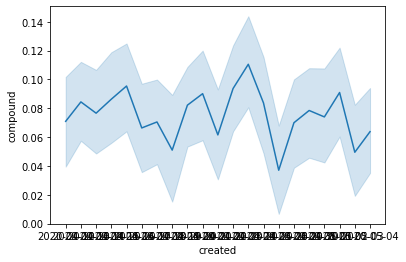

In [46]:
scr = df_us[['created', 'compound']]
sns.lineplot(x='created', y='compound', data=scr)

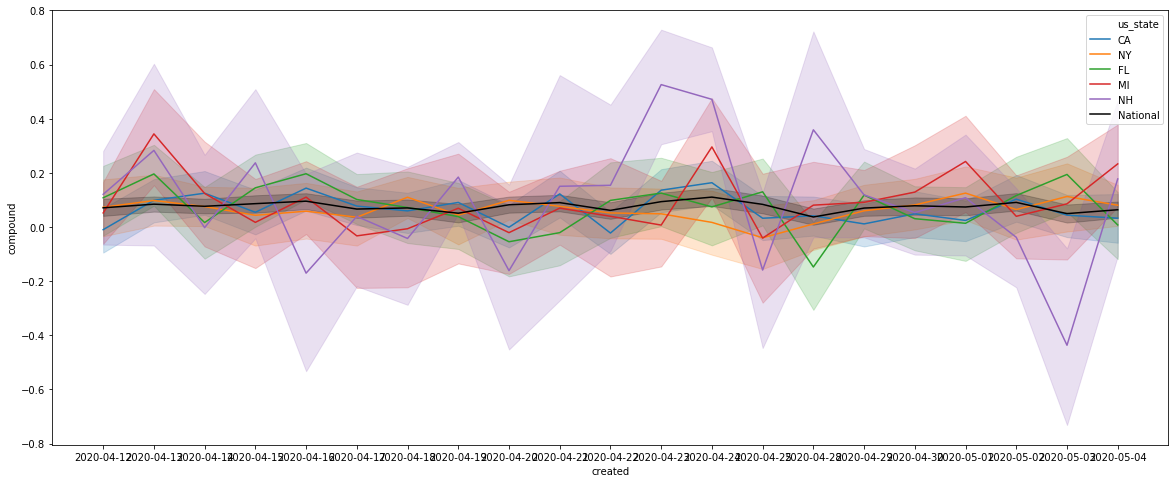

In [47]:
df_st = df_us[['created', 'compound', 'us_state']][(df_us.us_state.str.contains('CA|NY|NH|MI|FL', regex=True))]
plt.figure(figsize=(20,8))
#plt.ylim([-.25,.25])
sns.lineplot(x='created', y='compound', hue='us_state', data=df_st)
sns.lineplot(x='created', y='compound', data=scr, color='black', label='National')
plt.show()

In [48]:
df_us.head()

,created,id,user_id,text,location,city,country_code,country,us_state,compound
0,2020-04-18,1251661768172027904,503833546,the world isn’t ready for this month’s mixtape...,Jerk Nation,"Simi Valley, CA",US,United States,CA,0.3612
1,2020-04-18,1251661766032887808,1001222082422689793,@realDonaldTrump You tweeting this is propagan...,"Long Beach, CA","Cathedral City, CA",US,United States,CA,-0.5007
2,2020-04-18,1251661689336008707,184281174,TW: Weight tweet\n.\n.\n.\n.\nI’ve gained ~5 p...,"Chicago, IL","Wheaton, IL",US,United States,MD,0.5423
3,2020-04-18,1251661677516460035,62966681,Okay let’s do this. Saturday night. A quaranti...,"Midland, Michigan","Midland, MI",US,United States,TX,0.2263
4,2020-04-18,1251661616829001729,2619175823,i’m the least artsy person yet here i am paint...,"Salem, OR","Salem, OR",US,United States,OR,0.0000


In [49]:
df_base = df_us[['created', 'us_state', 'compound']]

In [50]:
df_base.head()

,created,us_state,compound
0,2020-04-18,CA,0.3612
1,2020-04-18,CA,-0.5007
2,2020-04-18,MD,0.5423
3,2020-04-18,TX,0.2263
4,2020-04-18,OR,0.0000


In [51]:
df_summary = df_base.groupby(['created', 'us_state']).sum()

In [52]:
df_summary

compound
created    us_state          
2020-04-12 AK          0.0000
           AL          2.8842
           AZ         -0.4602
           CA         -1.1255
           CO          0.1117
...                       ...
2020-05-04 VA          0.2643
           VT          0.3289
           WA          3.5959
           WI         -0.0557
           WV         -0.4939

[1005 rows x 1 columns]

In [53]:
c_min = min(df_summary.reset_index()['compound'])
c_max = max(df_summary.reset_index()['compound'])

In [54]:
df_summary = df_summary.reset_index()

In [55]:
df_summary['comp_scaled'] = (df_summary['compound'] - c_min)/(c_max-c_min)

In [56]:
df_summary

,created,us_state,compound,comp_scaled
0,2020-04-12,AK,0.0000,0.208804
1,2020-04-12,AL,2.8842,0.340351
2,2020-04-12,AZ,-0.4602,0.187815
3,2020-04-12,CA,-1.1255,0.157471
4,2020-04-12,CO,0.1117,0.213899
...,...,...,...,...
1000,2020-05-04,VA,0.2643,0.220859
1001,2020-05-04,VT,0.3289,0.223805
1002,2020-05-04,WA,3.5959,0.372811
1003,2020-05-04,WI,-0.0557,0.206264


In [57]:
df_summary = df_summary.drop(columns='compound').rename(columns={'comp_scaled':'compound'}).set_index(['created', 'us_state'])

In [58]:
a = df_summary[(df_summary.index.get_level_values('created') == '2020-04-12')]

In [59]:
a = pd.DataFrame(a.reset_index()).drop(columns='created')

In [60]:
a.us_state = a.us_state.apply(us.states.lookup)

In [61]:
a['state'] = None

In [62]:
for i in range(len(a)):
    a['state'].iloc[i] = a.us_state.iloc[i].name

In [66]:
import geoplot as gplt
import geoplot.crs as gcrs

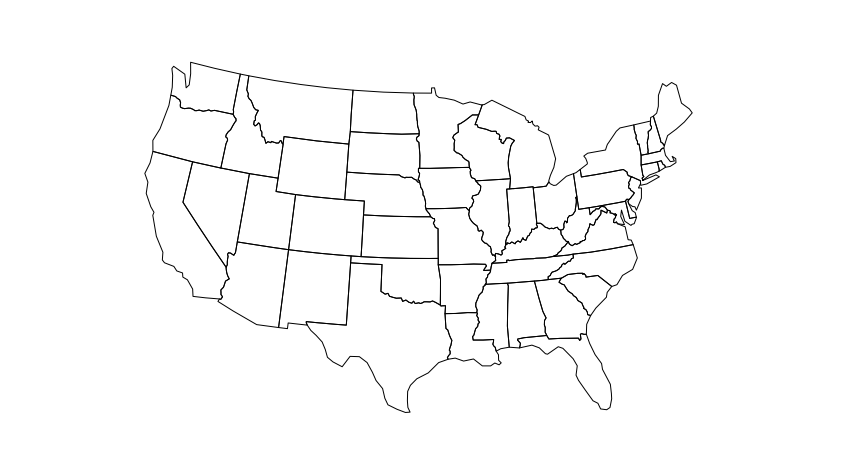

In [68]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea(), figsize=(15,10))

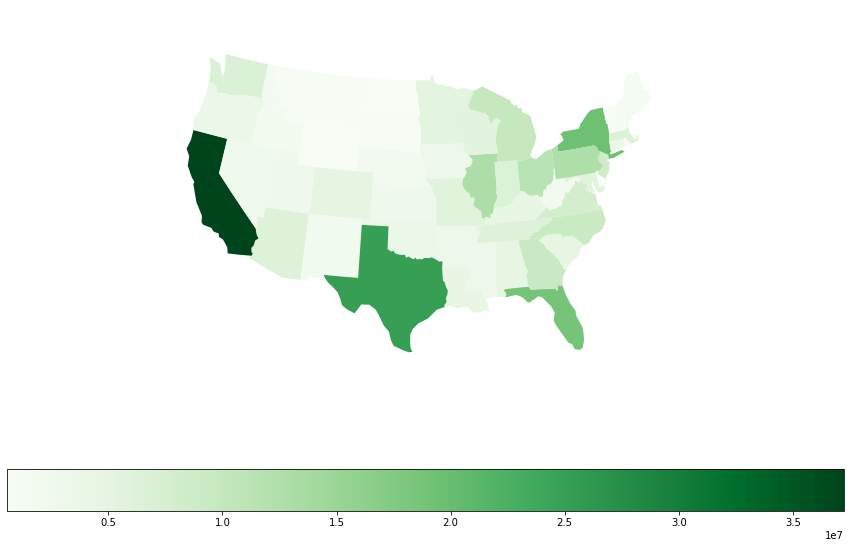

In [69]:
gplt.choropleth(
    contiguous_usa, hue='population', projection=gcrs.AlbersEqualArea(),
    legend=True,
    legend_kwargs={'orientation': 'horizontal'},
    cmap='Greens',
    figsize=(15,10)
)

In [70]:
contiguous_usa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
state         49 non-null object
adm1_code     49 non-null object
population    49 non-null int64
geometry      49 non-null geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 1.7+ KB


In [71]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
us_state    48 non-null object
compound    48 non-null float64
state       48 non-null object
dtypes: float64(1), object(2)
memory usage: 1.2+ KB


In [72]:
map_test = contiguous_usa.drop(columns='population').merge(a, left_on='state', right_on='state', how='left').drop(columns='us_state')
#a.merge(contiguous_usa.drop(columns='population'), left_on='us_state', right_on='state', how='right')

In [73]:
map_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 4 columns):
state        49 non-null object
adm1_code    49 non-null object
geometry     49 non-null geometry
compound     45 non-null float64
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.9+ KB


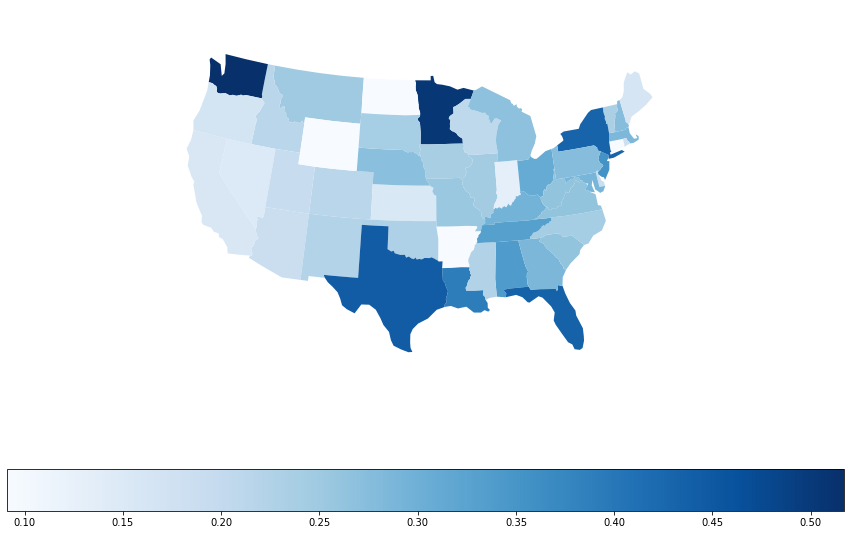

In [74]:
gplt.choropleth(
    map_test, hue='compound', projection=gcrs.AlbersEqualArea(),
    legend=True,
    legend_kwargs={'orientation': 'horizontal'},
    cmap='Blues',
    figsize=(15,10)
)

In [75]:
df_summary = df_summary.reset_index()

In [76]:
df_summary['state'] = None

In [77]:
for i in range(len(df_summary)):
    df_summary.state.iloc[i] = us.states.lookup(df_summary.us_state.iloc[i]).name

In [78]:
df_summary

,created,us_state,compound,state
0,2020-04-12,AK,0.208804,Alaska
1,2020-04-12,AL,0.340351,Alabama
2,2020-04-12,AZ,0.187815,Arizona
3,2020-04-12,CA,0.157471,California
4,2020-04-12,CO,0.213899,Colorado
...,...,...,...,...
1000,2020-05-04,VA,0.220859,Virginia
1001,2020-05-04,VT,0.223805,Vermont
1002,2020-05-04,WA,0.372811,Washington
1003,2020-05-04,WI,0.206264,Wisconsin


In [79]:
dates = df_summary.created.unique()

In [80]:
df_summary.describe()

,compound
count,1005.000000
mean,0.262950
std,0.102575
min,0.000000
25%,0.205603
50%,0.238378
75%,0.290710
max,1.000000


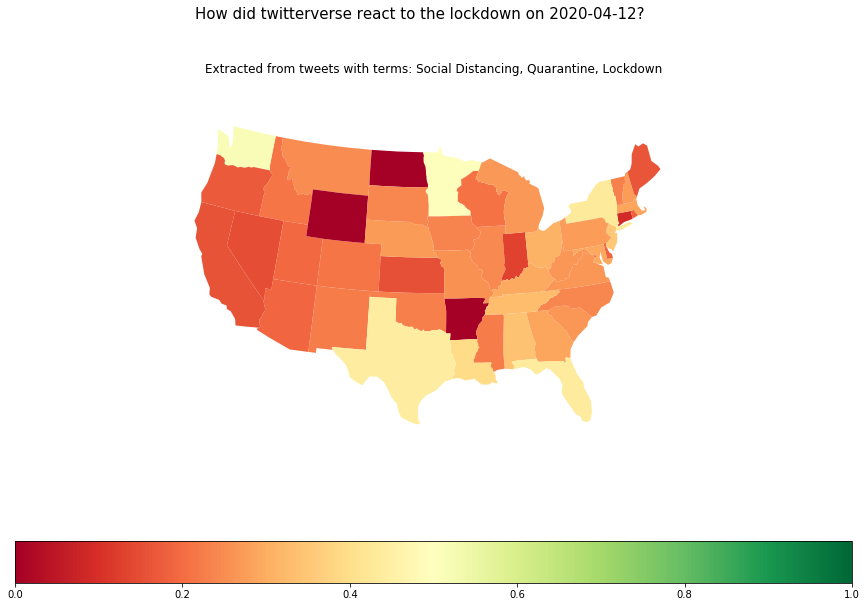

In [81]:
ax = gplt.choropleth(
    pd.merge(
        contiguous_usa.drop(columns='population'),
        df_summary[['state', 'compound']][(df_summary.created == dates[0])],
        on='state',
        how='left'
    ), 
    hue='compound', 
    norm=colors.Normalize(vmin=0, vmax=1),
    projection=gcrs.AlbersEqualArea(),
    legend=True,
    #legend_values=[0,1],
    #legend_labels=['High Negative', 'High Positive'],
    legend_kwargs={'orientation': 'horizontal'},
    cmap='RdYlGn',
    figsize=(15,10)
)
plt.suptitle('How did twitterverse react to the lockdown on '+str(dates[0])+'?', fontsize=15)
plt.title('Extracted from tweets with terms: Social Distancing, Quarantine, Lockdown')
plt.show()

In [ ]:
ax.get_figure().savefig('maps/test.jpg', dpi=80)

In [ ]:
for i in range(len(dates)):
    ax = gplt.choropleth(
        pd.merge(
            contiguous_usa.drop(columns='population'),
            df_summary[['state', 'compound']][(df_summary.created == dates[i])],
            on='state',
            how='left'
        ), 
        hue='compound', 
        norm=colors.Normalize(vmin=0, vmax=1),
        projection=gcrs.AlbersEqualArea(),
        legend=True,
        legend_kwargs={'orientation': 'horizontal'},
        cmap='RdYlGn',
        figsize=(15,10)
    )
    plt.suptitle('How did twitterverse react to the lockdown on '+str(dates[i])+'?', fontsize=15)
    plt.title('Extracted from tweets with terms: Social Distancing, Quarantine, Lockdown')
    ax.get_figure().savefig('maps/'+str(dates[i])+'.jpg', dpi=80)